<a href="https://colab.research.google.com/github/ehsankarami1358/ImagingSVHN/blob/main/UNET_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-yk__vw01
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-yk__vw01
  Resolved https://github.com/tensorflow/examples.git to commit fed63294c10c71b7da028e0e75de9ff68ac56d17
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1741282361.1454860421494433302046033067432040489300359736599-py3-none-any.whl size=301643 sha256=74201fa878843e2349f01dde75ca4997e3e86afcdbaa66cc124974e65c9cf760
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3j94spy/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 23.6 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset,info=tfds.load('oxford_iiit_pet:4.*.*',with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.GBC6I4_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.GBC6I4_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [4]:
def normalize(input_image,input_mask):
  input_image=tf.cast(input_image,tf.float32)/255.0
  input_mask-=1 #convert cls number to {0,1,2}
  return input_image,input_mask

In [5]:
@tf.function
def load_image_train(datapoint):
  input_image=tf.image.resize(datapoint['image'],(128,128))
  input_mask=tf.image.resize(datapoint['segmentation_mask'],(128,128))

  if tf.random.uniform(())>0.5:
    input_image=tf.image.flip_left_right(input_image)
    input_mask=tf.image.flip_left_right(input_mask)

  input_image,input_mask=normalize(input_image,input_mask)
  return input_image, input_mask

In [6]:
def load_image_test(datapoint):
  input_image=tf.image.resize(datapoint['image'],(128,128))
  input_mask=tf.image.resize(datapoint['segmentation_mask'],(128,128))

  if tf.random.uniform(())>0.5:
    input_image=tf.image.flip_left_right(input_image)
    input_mask=tf.image.flip_left_right(input_mask)

  input_image,input_mask=normalize(input_image,input_mask)
  return input_image, input_mask

In [7]:
TRAIN_LENGTH=info.splits['train'].num_examples
BATCH_SIZE=64
BUFFER_SIZE=1000
STEPS_PER_EPOCH=TRAIN_LENGTH//BATCH_SIZE

In [8]:
train=dataset['train'].map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test=dataset['test'].map(load_image_test)

In [9]:
train_dataset=train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset=train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset=test.batch(BATCH_SIZE)

In [10]:
def display(display_list):
  plt.figure(figsize=(15,15))
  title=['Input Image','True Mask','Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1,len(display_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

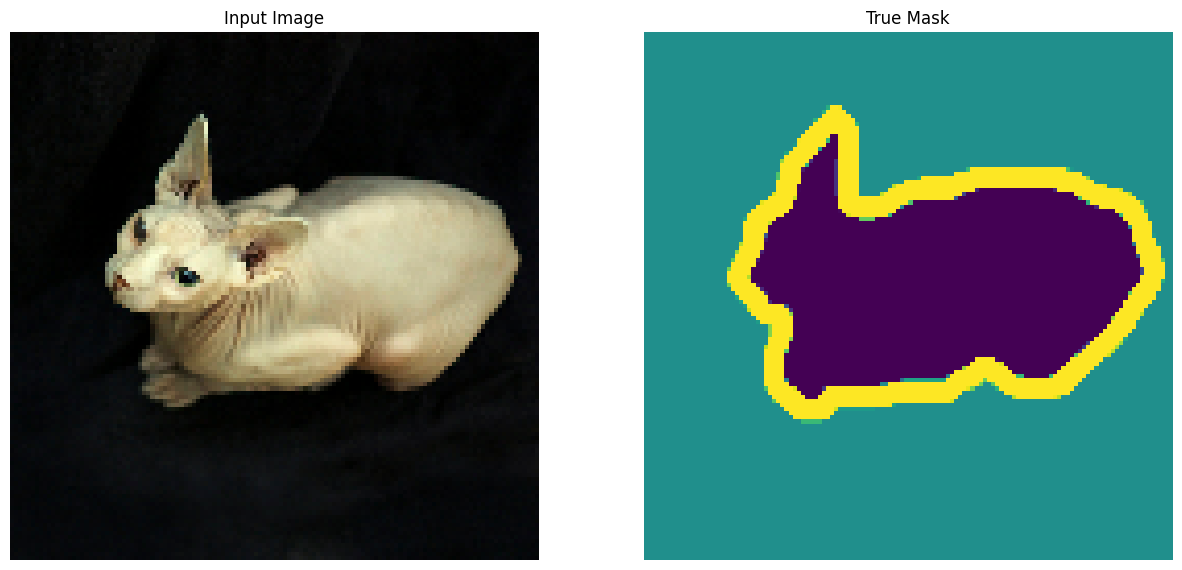

In [11]:
for image,mask in train.take(1):
  sample_image,sample_mask=image,mask
display([sample_image,sample_mask])

In [12]:
OUTPUT_CHANNELS=3

In [13]:
base_model=tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

layer_names=['block_1_expand_relu','block_3_expand_relu','block_6_expand_relu','block_13_expand_relu','block_16_project']
layers=[base_model.get_layer(name).output for name in layer_names]

down_stack=tf.keras.Model(inputs=base_model.input,outputs=layers)

down_stack.trainable=False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
down_stack.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 1,841,984 (7.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,841,984 (7.03 MB)

In [15]:
upstack=[
    pix2pix.upsample(512,3),
    pix2pix.upsample(256,3),
    pix2pix.upsample(128,3),
    pix2pix.upsample(64,3),
]


In [26]:
def unet_model(output_channels):
  inputs=tf.keras.layers.Input(shape=[128,128,3])
  # Get the output from down_stack model
  skips = down_stack(inputs)
  X=skips[-1]
  skips=reversed(skips[:-1])

  for up,skip in zip(upstack,skips):
    X=up(X)
    concat=tf.keras.layers.Concatenate()
    X=concat([X,skip])

  # The final layer should be outside the loop to ensure correct output shape
  last=tf.keras.layers.Conv2DTranspose(
      output_channels,3,strides=2,padding='same'
  )
  X=last(X)
  return tf.keras.Model(inputs=inputs,outputs=X) # Return the model after the loop


In [27]:
model=unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 64, 64, 96),   │      1,841,984 │ input_layer_4[0][0]    │
│                           │ (None, 32, 32, 144),   │                │                        │
│                           │ (None, 16, 16, 192),   │                │                        │
│                           │ (None, 8, 8, 576),     │                │                        │
│                           │ (None, 4, 4, 320)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 8, 8, 512)      │      1,476,608 │ functional[2][4]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 8, 8, 1088)     │              0 │ sequential[2][0],      │
│ (Concatenate)             │                        │                │ functional[2][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 16, 16, 256)    │      2,507,776 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 16, 16, 448)    │              0 │ sequential_1[0][0],    │
│ (Concatenate)             │                        │                │ functional[2][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 128)    │        516,608 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 32, 32, 272)    │              0 │ sequential_2[0][0],    │
│ (Concatenate)             │                        │                │ functional[2][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 64, 64, 64)     │        156,928 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 64, 64, 160)    │              0 │ sequential_3[0][0],    │
│ (Concatenate)             │                        │                │ functional[2][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 128, 128, 3)    │          4,323 │ concatenate_5[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,504,227 (24.81 MB)

 Trainable params: 4,660,323 (17.78 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

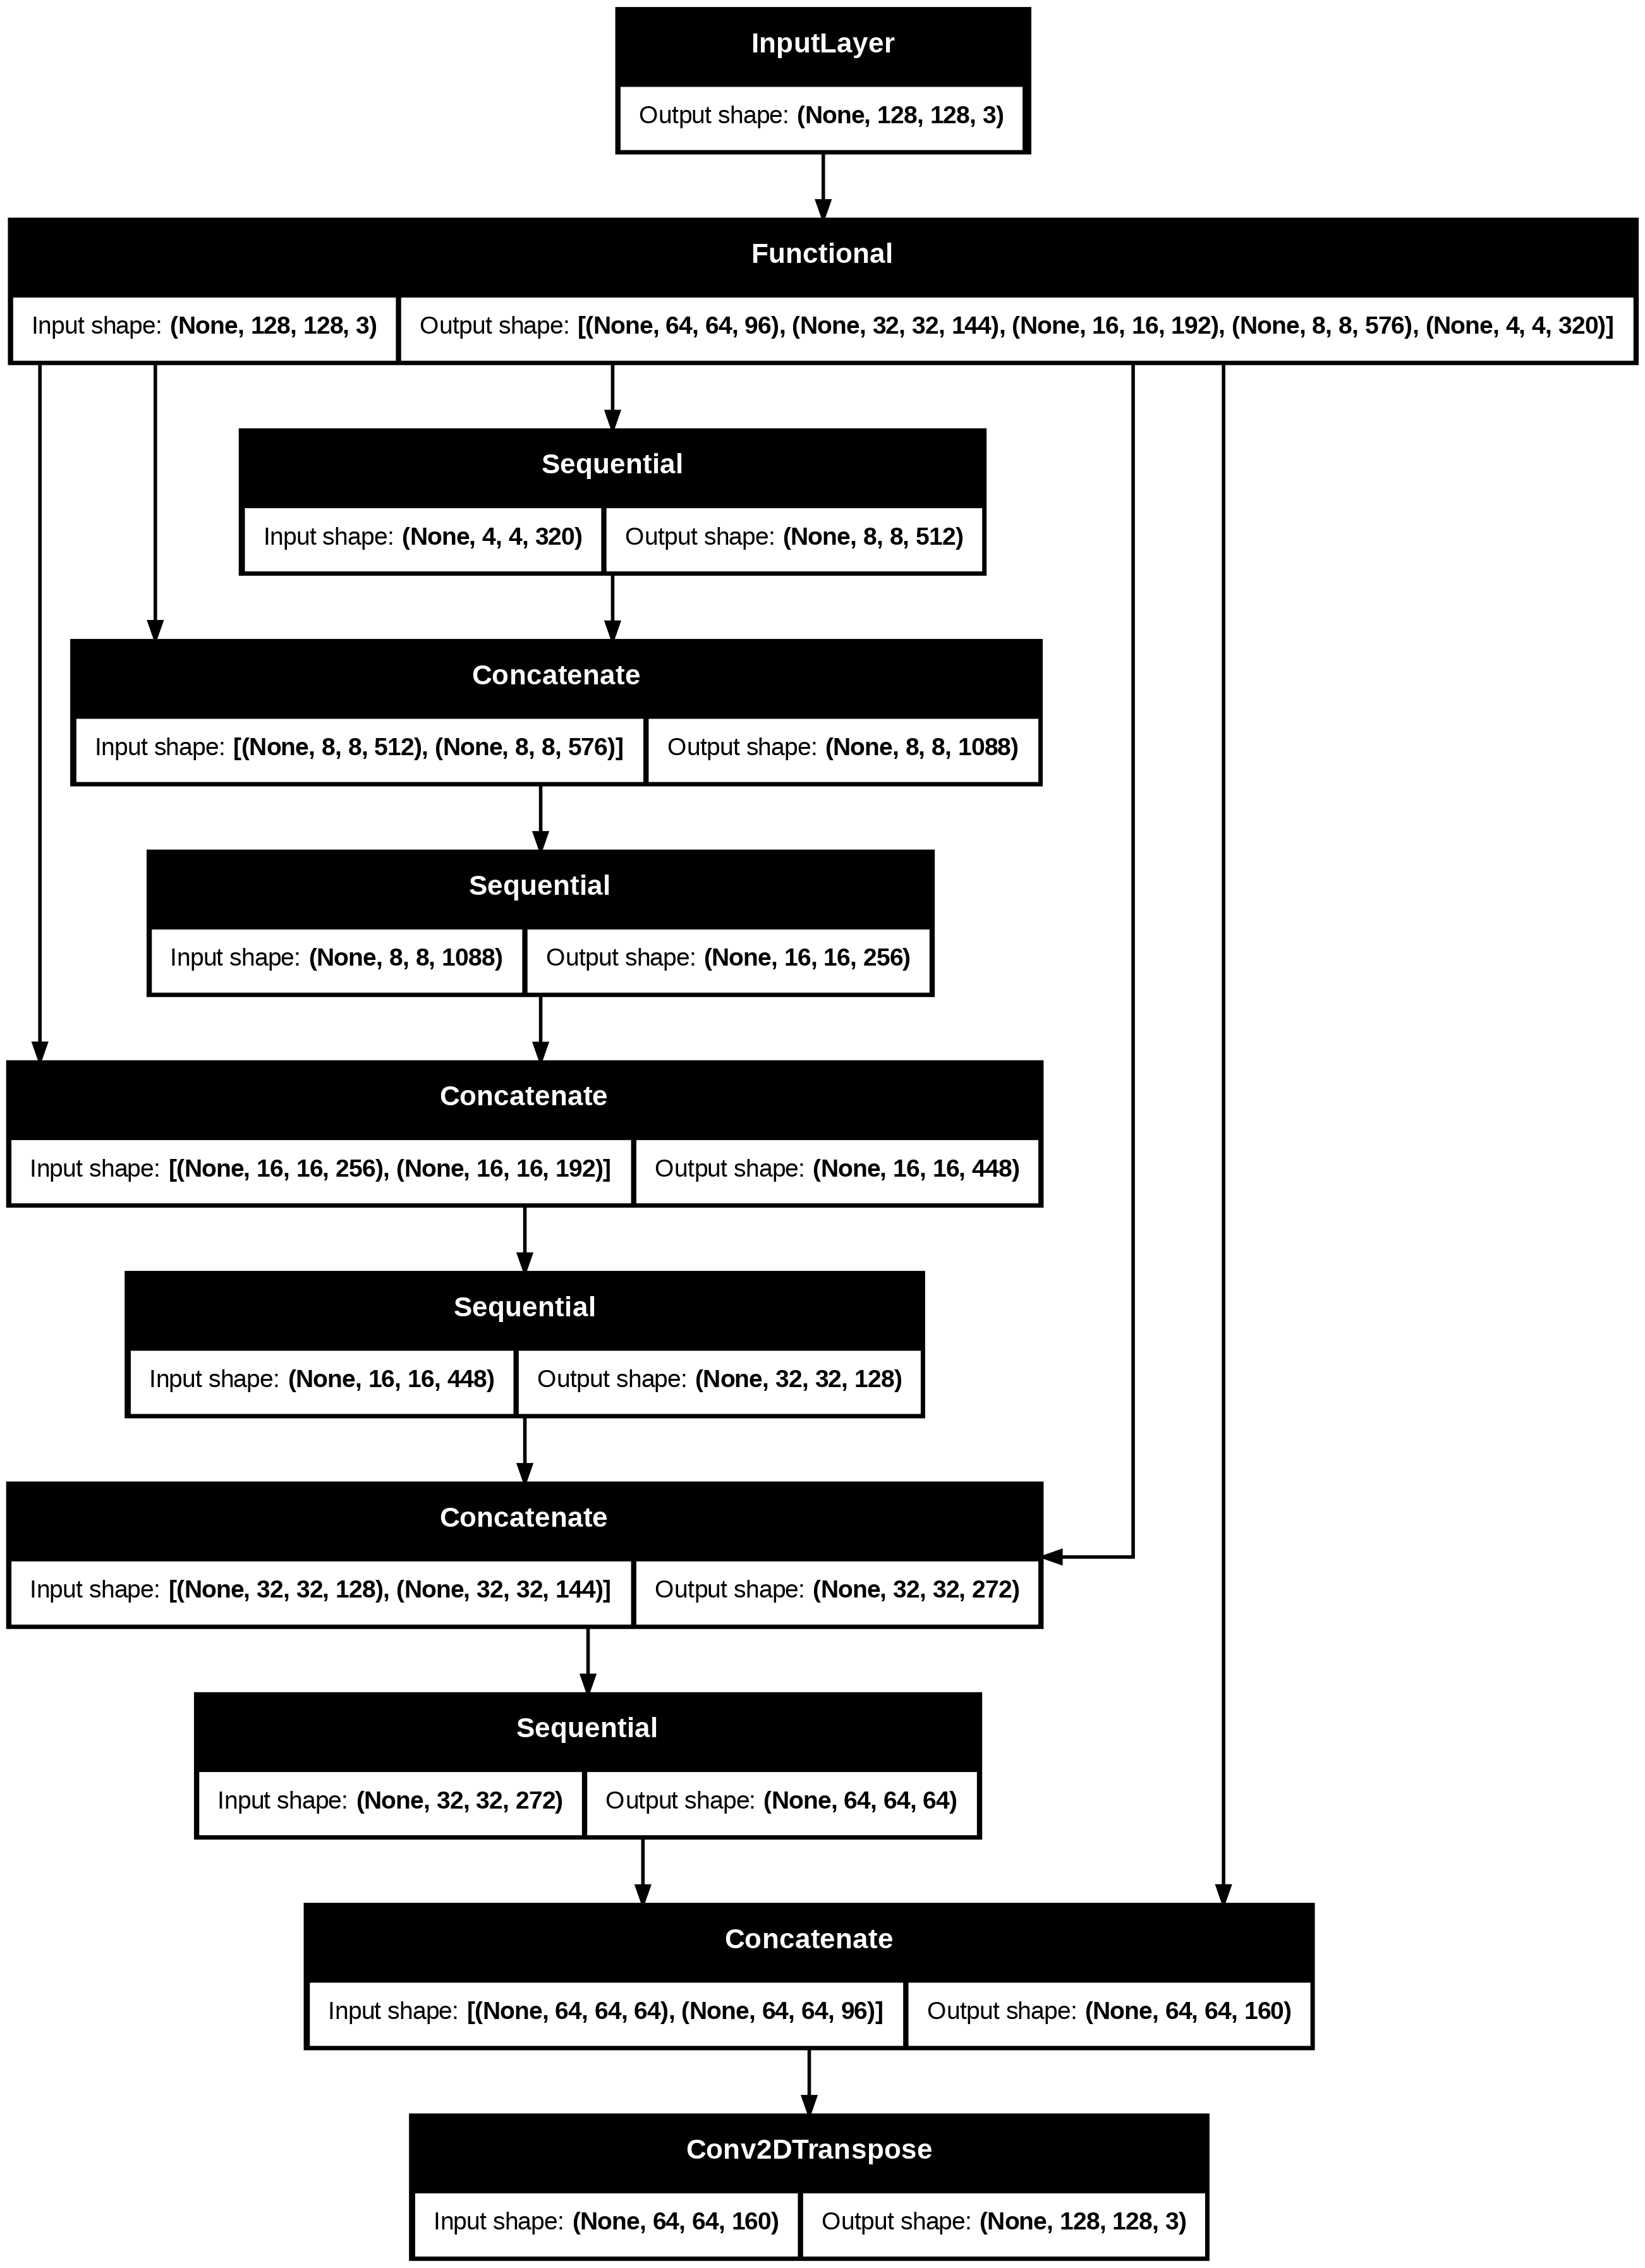

In [28]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [29]:
model=unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 64, 64, 96),   │      1,841,984 │ input_layer_8[0][0]    │
│                           │ (None, 32, 32, 144),   │                │                        │
│                           │ (None, 16, 16, 192),   │                │                        │
│                           │ (None, 8, 8, 576),     │                │                        │
│                           │ (None, 4, 4, 320)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 8, 8, 512)      │      1,476,608 │ functional[3][4]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 8, 8, 1088)     │              0 │ sequential[3][0],      │
│ (Concatenate)             │                        │                │ functional[3][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 16, 16, 256)    │      2,507,776 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 16, 16, 448)    │              0 │ sequential_1[1][0],    │
│ (Concatenate)             │                        │                │ functional[3][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 128)    │        516,608 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 32, 32, 272)    │              0 │ sequential_2[1][0],    │
│ (Concatenate)             │                        │                │ functional[3][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 64, 64, 64)     │        156,928 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 64, 64, 160)    │              0 │ sequential_3[1][0],    │
│ (Concatenate)             │                        │                │ functional[3][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_7        │ (None, 128, 128, 3)    │          4,323 │ concatenate_9[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,504,227 (24.81 MB)

 Trainable params: 4,660,323 (17.78 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

In [30]:
def creat_mask(pred_mask):
  pred_mask=tf.argmax(pred_mask,axis=-1)
  pred_mask=pred_mask[...,tf.newaxis]
  return pred_mask[0]

In [31]:
def show_predictions(dataset=None,num=1):
  if dataset:
    for image,mask in dataset.take(num):
      pred_mask=model.predict(image)
      display([image[0],mask[0],creat_mask(pred_mask)]) # The typo was in this line

  else:
    display([sample_image,sample_mask,
             creat_mask(model.predict(sample_image[tf.newaxis,...]))])

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step


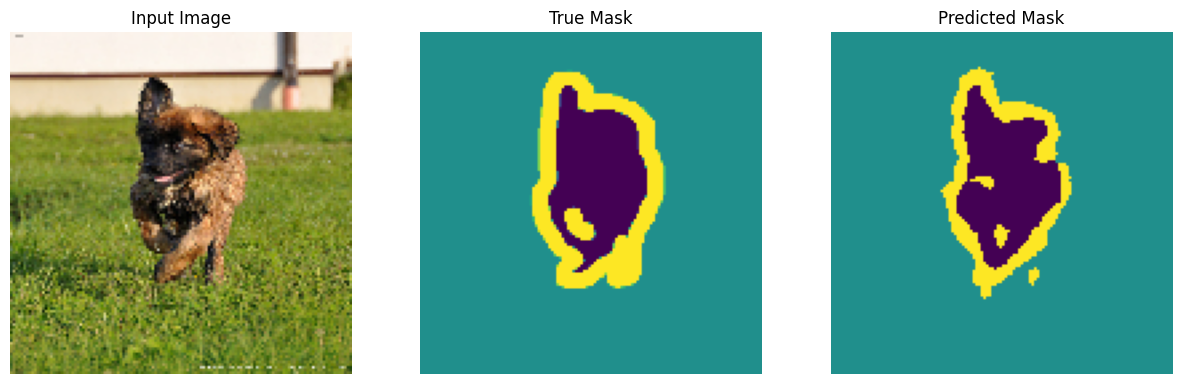

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


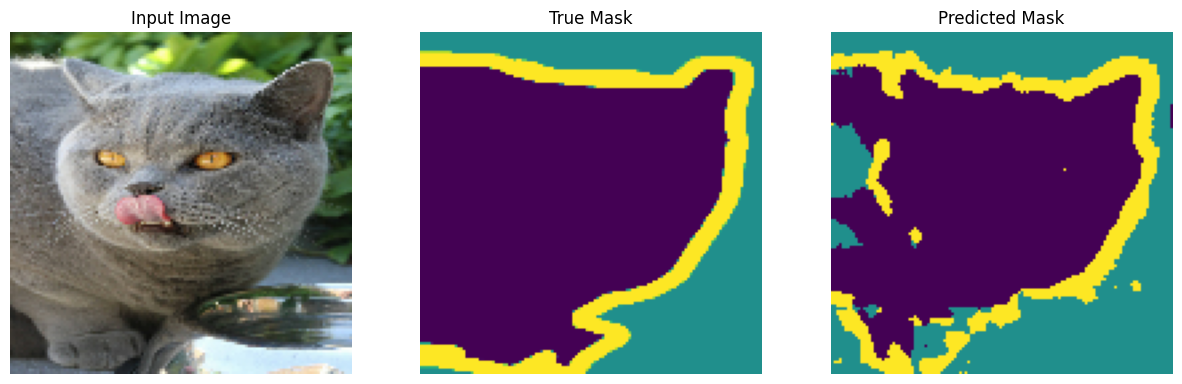

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


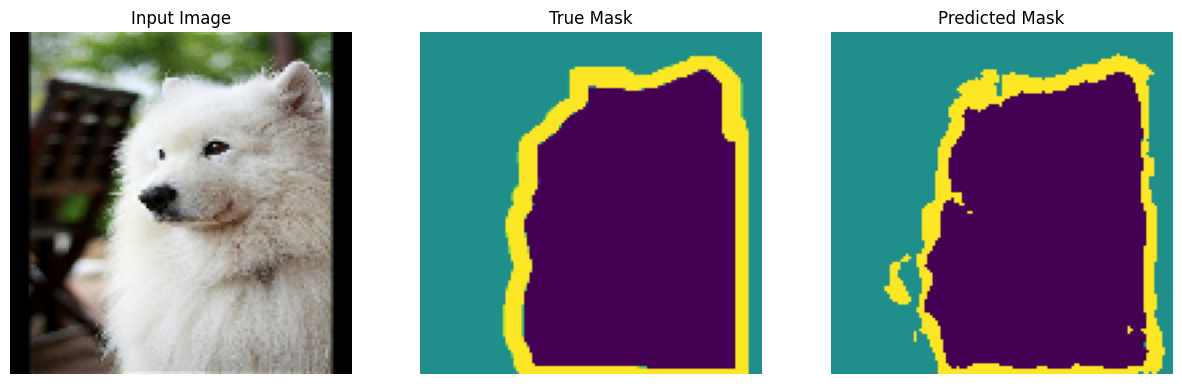

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


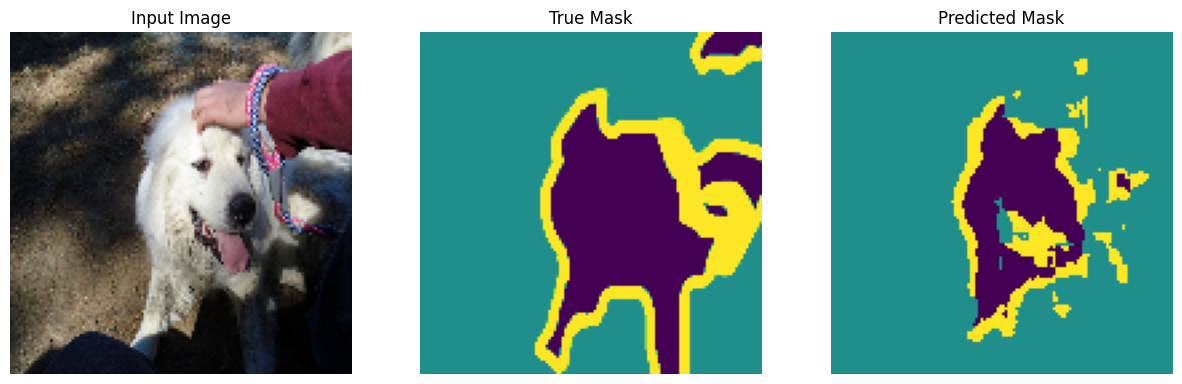

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


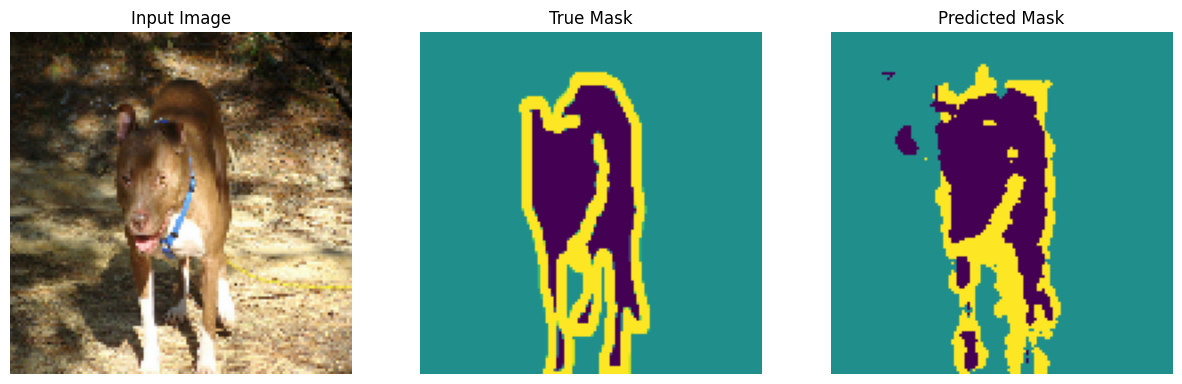

In [39]:
show_predictions(test_dataset,5)

In [33]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs=None):
    clear_output(wait=True)
    show_predictions()
    print('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


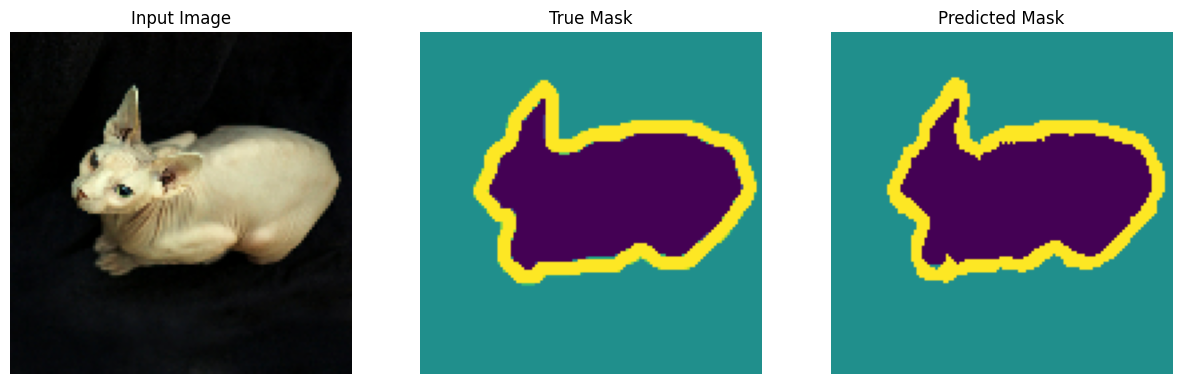


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9644 - loss: 0.0687 - val_accuracy: 0.8809 - val_loss: 0.5060


In [36]:
EPOCHS=20
VAL_SUBSPLITS=5
VALIDATION_STEPS=info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history=model.fit(train_dataset,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,validation_data=test_dataset,
                         callbacks=[DisplayCallback()])

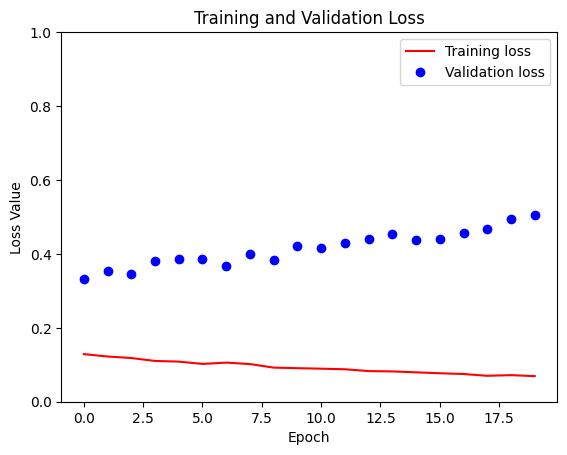

In [38]:
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
epochs=range(EPOCHS)
plt.figure()
plt.plot(epochs,loss,'r',label='Training loss')
plt.plot(epochs,val_loss,'bo',label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0,1])
plt.legend()
plt.show()